Import Libraries

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

## Gym Agent and Environment Class

#### Things to Consider 
1. This is limited to drilling interactions, production is not considered in reward
2. SHL is selected by user but should be something we included in the optimization 
3. The action and observations space logic must be preserved for the RL Q-Learning Flow, but the logic is not really dependant on these
4. Collision logic just prevents agents from wrapping around environment on Eastern and Western boundaries. It also prevents from hitting boundaries North and South. Logic just causes a bounce back effect that forces the agent to perform the opposite action ex: if it is going east and hits a boundary, it will go west for that action instead. 
5. Realistically all that can be optimized now is drilling direction based on available drill pipe


All models are created using tiled, here is the download link https://www.mapeditor.org/

location = [row,col]

In [2]:
from wildcatter.environment import SimpleDriller

Create the Env Object

In [9]:
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=50, delim=",")

env = SimpleDriller(env_config)

episodes = 1
for episode in range(1, episodes + 1):
    print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
    score = 0

    while not done:
        # env.render()
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        score += reward

    print(f"Final Trajectory:{env.trajectory}")
    print("Campaign:{} Score:{}".format(episode, score))
    print("------------------------------------------")

Beginning Drill Campaign: 1
Final Trajectory:[[1, 20], [1, 19], [1, 18], [1, 17], [1, 16], [1, 15], [1, 14], [2, 14], [2, 13], [3, 13], [4, 13], [4, 14], [3, 14], [3, 15], [2, 15], [2, 16], [3, 16], [4, 16], [4, 15], [5, 15], [5, 16], [6, 16], [7, 16], [8, 16], [8, 15], [7, 15], [6, 15], [6, 14], [5, 14], [5, 13], [5, 12], [5, 11], [6, 11], [7, 11], [7, 12], [7, 13], [8, 13], [9, 13], [10, 13], [10, 14], [11, 14], [11, 15], [11, 16], [10, 16], [10, 15], [9, 15], [9, 14], [8, 14], [7, 14]]
Campaign:1 Score:6.0
------------------------------------------


## Actual Execution of Agent/Env Interactions

There are some basic print statements to help users understand what is going on since we don't have a UI or pygame visual to analyze.

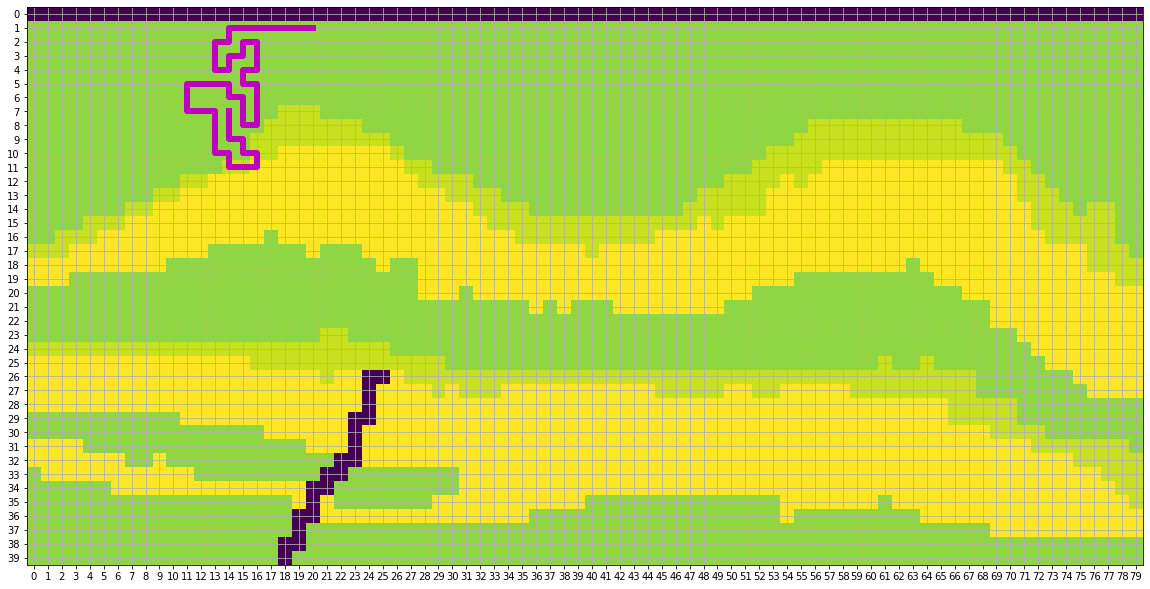

In [10]:
df = pd.DataFrame(env.trajectory, columns=["rows", "colums"])

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.grid()
plt.plot(df["colums"], df["rows"], "-", c="m", linewidth=6)

## PPO TESTS

In [29]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.2     |
|    ep_rew_mean     | 5.53     |
| time/              |          |
|    fps             | 2515     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36.8        |
|    ep_rew_mean          | 8.55        |
| time/                   |             |
|    fps                  | 1430        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013634276 |
|    clip_fraction        | 0.0814      |
|    clip_range           | 0.2         |
|    entropy_loss   

To see tensorboard run this from CLI.

Note Ray needs `grpcio`. On new Macs this has to be installed from conda or be built from scratch for M1 silicon.

The pip version doesn't work, and ray crashes.

```shell
tensorboard --logdir ~/ray_results/
```

In [46]:
# instantiate env class
env = SimpleDriller(env_config)

# run until episode ends
episode_reward = 0
done = False
obs = env.reset()
while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

trajectory = env.trajectory
print(episode_reward)

53.0


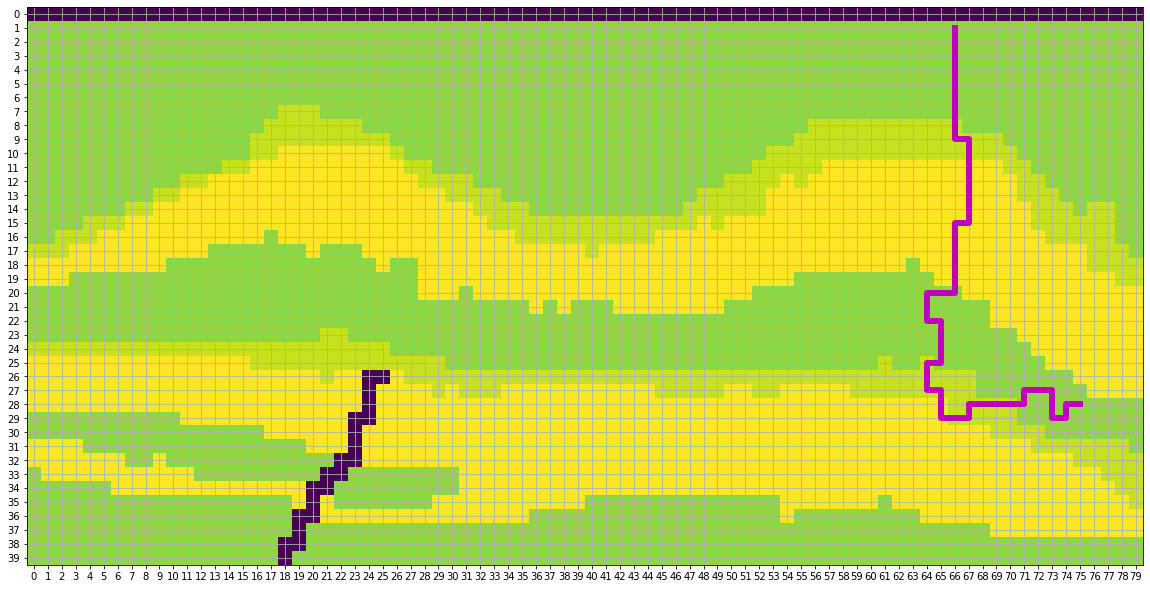

In [47]:
df = pd.DataFrame(env.trajectory, columns=["rows", "colums"])

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.grid()
plt.plot(df["colums"], df["rows"], "-", c="m", linewidth=6)

<Figure size 432x288 with 0 Axes>

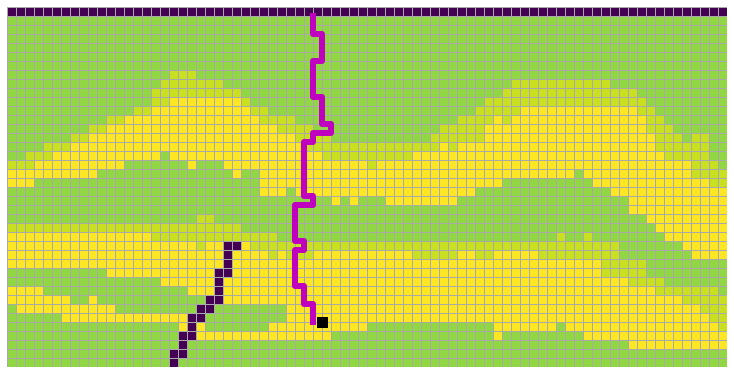

In [8]:
import matplotlib.animation as animation

plt.close("all")

fig = plt.figure(facecolor="white")
fig = plt.figure(figsize=(10, 5))
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)
plt.pcolormesh(
    env.model, vmin=-10, vmax=2, antialiased=True, shading="auto", edgecolors="darkgray"
)
plt.gca().invert_yaxis()

borehole = ax.plot(df["colums"][0], df["rows"][0], ls="-", c="m", lw=6, zorder=10)
bit = ax.scatter(df["colums"][0], df["rows"][0], marker="s", s=100, c="k", zorder=20)


def animate_drill(i):
    borehole[0].set_data(df["colums"][:i], df["rows"][:i])
    bit.set_offsets([df["colums"][i], df["rows"][i]])


anim = animation.FuncAnimation(fig, frames=50, func=animate_drill)

FFwriter = animation.FFMpegWriter(fps=10, bitrate=500)
anim.save("animation.mp4", writer=FFwriter)